# Star Man Image Generator Project

Questo notebook ci porta a confrontare due modelli dopo un fine-tuning, i due modelli sono:
1. Stable Diffusion v1.5 (Hugging Face Model Hub)
2. OpenJourney (Hugging Face Model Hub)

Il progetto integra il dataset di astroNN chiamato Galaxy 10 SDSS

**Developed by:** Angela Rossi, matricola 174288, University of Udine, 2025.    
**External Sources:** AstroNN, Hugging Face Model Hub    
**Special Thanks To:** Stack Overflow, Reddit, and the Wikis

## Libraries and Imports

In [ ]:
# Ecosistema PyTorch (deep learning framework)
!pip install -q torch torchvision torchaudio

# Librerie per modelli di diffusione e transformers, utilities di Hugging Face
!pip install -q diffusers transformers accelerate

# Utility per immagini e richieste HTTP
!pip install -q requests pillow matplotlib

In [15]:
import tensorflow as tf # framework principale per reti neurali
from tensorflow import keras # API di tensorflow
from tensorflow.keras import layers # contiene i layers delle reti neurali (Conv2D, Dense)
from tensorflow.keras.preprocessing.image import ImageDataGenerator # per creare batch di immagini con data augmentation e per non caricare tutto il dataset nella RAM
from tensorflow.keras.optimizers import Adam # ottimizzatore
import numpy as np # calcolo
import pandas as pd # manipolazione dati tabulari
from PIL import Image # carica e manipola immagini
import cv2 # libreria per computer vision
import matplotlib.pyplot as plt # per creare grafici
import seaborn as sns # basata su matplotlib, crea grafici più belli
import os # interagisce col sistema operativo
import glob # trova file che matchano un pattern
from tqdm import tqdm # progress bar
import random # shuffle dati

In [ ]:
import torch  # Importazione di PyTorch per il calcolo tensoriale e le GPU

# Seleziona automaticamente il dispositivo (GPU se disponibile, altrimenti CPU)
# Verifica se CUDA (GPU NVIDIA) è disponibile, altrimenti usa CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Stampa il dispositivo che verrà utilizzato
print(f"Utilizzo dispositivo: {device}")

# Se rileva una GPU, mostra informazioni dettagliate
if device == "cuda":
    # Ottiene e stampa il nome del modello della GPU
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    
    # Ottiene e stampa la memoria totale della GPU in GB
    # torch.cuda.get_device_properties(0) restituisce le proprietà della GPU
    # .total_memory contiene la memoria totale in byte
    # diviso per 1e9 (1 miliardo) per convertire in GB, formattato con 2 decimali
    print(f"Memoria GPU disponibile: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    # Messaggio informativo se non viene rilevata una GPU
    print("Nessuna GPU rilevata, utilizzo CPU (più lento)")

Utilizzo dispositivo: cpu
Nessuna GPU rilevata, utilizzo CPU (più lento)


In [ ]:
# Installazione della libreria astroNN
! pip install astroNN

# Importazione del modulo galaxy10sdss dalla libreria astroNN.datasets
from astroNN.datasets import galaxy10sdss

# Caricamento del dataset Galaxy10 SDSS che contiene immagini di galassie
# images: array numpy con le immagini delle galassie
# labels: array numpy con le etichette di classificazione (0-9)
images, labels = galaxy10sdss.load_data()

# Stampa la forma/dimensioni del dataset originale
# images.shape restituisce (numero_immagini, altezza, larghezza, canali)
print(f"Dataset originale: {images.shape}")

# Definisce la dimensione target per il ridimensionamento delle immagini
TARGET_SIZE = 64

# Ridimensiona tutte le immagini a 64x64 pixel usando TensorFlow
# tf.image.resize() ridimensiona le immagini alla dimensione specificata
# .numpy() converte il risultato da tensore TensorFlow a array numpy
images = tf.image.resize(images, [TARGET_SIZE, TARGET_SIZE]).numpy()

# Normalizza i valori dei pixel dell'immagine da [0,255] a [-1,1]
# images.astype('float32') converte i pixel in float per evitare problemi di divisione
# -127.5 sposta l'intervallo da [0,255] a [-127.5,127.5]
# /127.5 scala l'intervallo a [-1,1]
images = (images.astype('float32') - 127.5) / 127.5

# Stampa la forma/dimensioni del dataset dopo il processing
print(f"Dataset processato: {images.shape}")

c:\Users\angela.rossi\AppData\Local\Programs\Python\Python313\Lib\site-packages\astroNN\__init__.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution


C:\Users\angela.rossi\.astroNN\datasets\Galaxy10.h5 was found!
Dataset originale: (21785, 69, 69, 3)
Dataset processato: (21785, 64, 64, 3)


## Model 1: Stable Diffusion 1.5

In [ ]:
# Pipeline di Stable Diffusion dalla libreria diffusers di Hugging Face
from diffusers import StableDiffusionPipeline

# Importazione di PyTorch per il calcolo tensoriale e le GPU
import torch

# Definisce una classe per generare immagini con Stable Diffusion
class StableDiffusionGenerator:
    """
    Generatore di immagini con Stable Diffusion v1.5
    Basato su: Hugging Face Diffusers
    Implementazione: Angela Rossi
    """
    
    # Metodo costruttore della classe, viene chiamato quando si crea un'istanza
    def __init__(self, model_id="runwayml/stable-diffusion-v1-5"):
        # Memorizza l'ID del modello (default: Stable Diffusion v1.5)
        self.model_id = model_id
        
        # Pipeline inizialmente vuota (verrà caricata on-demand quando serve)
        self.pipeline = None
        
        # Definisce il dispositivo all'interno della classe
        # Se c'è una GPU disponibile usa "cuda", altrimenti "cpu"
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    # Metodo per caricare il modello in memoria
    def load_model(self):
        """Carica il modello in memoria"""
        # Controlla se il modello non è già stato caricato
        if self.pipeline is None:
            # Messaggio di informazione all'utente
            print(f"Caricamento Stable Diffusion v1.5...")
            
            # Carica la pipeline da Hugging Face Hub
            self.pipeline = StableDiffusionPipeline.from_pretrained(
                # ID del modello preaddestrato
                self.model_id,
                
                # Usa float16 su GPU per risparmiare memoria, float32 su CPU
                torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
                
                # Disabilita il safety checker (filtro di sicurezza per contenuti)
                safety_checker=None,
                
                # Disabilita il requirement del safety checker
                requires_safety_checker=False
            )
            
            # Sposta la pipeline sul dispositivo appropriato (GPU/CPU)
            self.pipeline = self.pipeline.to(self.device)
            
            # Messaggio di conferma
            print("Modello caricato con successo")

    # Metodo per generare un'immagine da un prompt testuale
    def generate_image(self, prompt, num_inference_steps=50, guidance_scale=7.5):   #inference steps = numero di step di denoising, guidance scale = quanto seguire il prompt
        """
        Genera un'immagine dal prompt

        Args:
            prompt: testo descrittivo dell'immagine
            num_inference_steps: numero di step di denoising
            guidance_scale: quanto seguire il prompt

        Returns:
            Immagine PIL
        """

        # Assicura che il modello sia caricato prima della generazione
        self.load_model()

        # Blocco try-catch per gestire eventuali errori durante la generazione
        try:
            # Usa autocast per ottimizzare i calcoli sul dispositivo
            # autocast gestisce automaticamente la precisione (mixed precision)
            with torch.autocast(self.device):
                # Genera l'immagine usando la pipeline
                image = self.pipeline(
                    # Prompt testuale che descrive l'immagine da generare
                    prompt,
                    
                    # Numero di passi di denoising (più passi = migliore qualità ma più lento)
                    num_inference_steps=num_inference_steps,
                    
                    # Quanto seguire fedelmente il prompt (valori più alti = più fedeltà)
                    guidance_scale=guidance_scale,
                    
                    # Altezza dell'immagine generata in pixel
                    height=512,
                    
                    # Larghezza dell'immagine generata in pixel
                    width=512
                ).images[0]  # Prende la prima immagine dalla lista restituita
            
            # Restituisce l'immagine generata (oggetto PIL Image)
            return image
        
        # Se si verifica un errore durante la generazione
        except Exception as e:
            # Stampa il messaggio di errore
            print(f"Errore generazione immagine: {e}")
            
            # Restituisce None per indicare che la generazione è fallita
            return None

# Creazione di un'istanza della classe StableDiffusionGenerator
# Questo inizializza il generatore ma non carica ancora il modello in memoria
sd_generator = StableDiffusionGenerator()

c:\Users\angela.rossi\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Model 2: Open Journey



In [ ]:
# Pipeline di Stable Diffusion dalla libreria diffusers
from diffusers import StableDiffusionPipeline

# Importazione di PyTorch per il calcolo tensoriale
import torch

# Importa la libreria PIL per la gestione delle immagini
from PIL import Image

# Definisce una classe per generare immagini con OpenJourney
class OpenJourneyGenerator:
    """
    Generatore di immagini con OpenJourney
    Basato su: Hugging Face Diffusers
    Implementazione: Angela Rossi
    """

    # Metodo costruttore della classe
    def __init__(self, model_name="prompthero/openjourney", device=None):
        # Seleziona dispositivo: usa quello fornito, oppure GPU se disponibile, altrimenti CPU
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        # Stampa informazioni sull'inizializzazione
        print(f"Inizializzazione del modello {model_name} su {self.device}...")
        
        # Carica la pipeline di OpenJourney da Hugging Face Hub
        self.pipe = StableDiffusionPipeline.from_pretrained(
            # Nome del modello OpenJourney su Hugging Face
            model_name,
            # Usa float16 su GPU per risparmiare memoria, float32 su CPU
            torch_dtype=torch.float16 if self.device == "cuda" else torch.float32
        ).to(self.device)  # Sposta il modello sul dispositivo (GPU/CPU)

    # Metodo per generare immagini da prompt testuali
    def generate_image(self, prompt, size="512x512", guidance_scale=7.5, num_inference_steps=50):
        """
        Genera un'immagine dal prompt usando OpenJourney

        Args:
            prompt: testo descrittivo dell'immagine
            size: dimensione immagine ("512x512", ecc.)
            guidance_scale: forza della guida del testo
            num_inference_steps: numero di passi di inferenza

        Returns:
            Immagine PIL
        """
        try:
            # Estrae larghezza e altezza dalla stringa size (es: "512x512" -> 512, 512)
            # .lower() converte in minuscolo, .split("x") divide la stringa, map(int) converte in interi
            width, height = map(int, size.lower().split("x"))
            
            # Messaggio di informazione all'utente
            print("Generazione con OpenJourney...")
            
            # Genera l'immagine usando la pipeline
            image = self.pipe(
                # Prompt testuale che descrive cosa generare
                prompt=prompt,
                # Larghezza dell'immagine in pixel
                width=width,
                # Altezza dell'immagine in pixel
                height=height,
                # Quanto seguire fedelmente il prompt (valori più alti = più fedeltà al testo)
                guidance_scale=guidance_scale,
                # Numero di passi di denoising (più passi = migliore qualità ma più lento)
                num_inference_steps=num_inference_steps
            ).images[0]  # Prende la prima immagine dalla lista restituita
            
            # Restituisce l'immagine generata come oggetto PIL
            return image
        
        # Gestisce eventuali errori durante la generazione
        except Exception as e:
            # Stampa il messaggio di errore
            print(f"Errore generazione OpenJourney: {e}")
            
            # Restituisce None per indicare fallimento
            return None

# Crea un'istanza del generatore OpenJourney con il modello specificato
openjourney_generator = OpenJourneyGenerator("prompthero/openjourney")

Inizializzazione del modello prompthero/openjourney su cpu...


Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


## Comparatore

In [7]:
# Definisce una classe per confrontare immagini generate da due modelli diversi
class ImageComparator:
    """
    Sistema per generare e comparare immagini da entrambi i modelli
    Sviluppato da: Angela Rossi
    """

    # Metodo costruttore della classe
    def __init__(self, model1, model2):
        # Memorizza il primo modello (tipicamente Stable Diffusion)
        self.model1 = model1  # Stable Diffusion
        
        # Memorizza il secondo modello (tipicamente OpenJourney)
        self.model2 = model2  # OpenJourney
        
        # Lista per tenere traccia dello storico di tutte le generazioni
        self.generation_history = []

    # Metodo per generare immagini con entrambi i modelli usando lo stesso prompt
    def generate_comparison(self, prompt):
        """
        Genera immagini con entrambi i modelli

        Args:
            prompt: testo descrittivo dell'immagine

        Returns:
            Dizionario con risultati
        """
        # Stampa il prompt usato per la generazione
        print(f"Prompt: {prompt}")

        # Crea un dizionario per memorizzare i risultati della generazione corrente
        results = {
            'prompt': prompt,  # Memorizza il prompt originale
            'timestamp': datetime.now().isoformat(),  # Aggiunge timestamp corrente
            'images': {}  # Dizionario vuoto per le immagini generate
        }

        # Genera immagine con il primo modello (Stable Diffusion)
        print("Generazione con Stable Diffusion v1.5...")
        sd_image = self.model1.generate_image(prompt)
        # Se la generazione ha successo, aggiungi l'immagine ai risultati
        if sd_image:
            results['images']['stable_diffusion'] = sd_image

        # Genera immagine con il secondo modello (OpenJourney)
        print("Generazione con OpenJourney...")
        oj_image = self.model2.generate_image(prompt)
        # Se la generazione ha successo, aggiungi l'immagine ai risultati
        if oj_image:
            results['images']['openjourney'] = oj_image

        # Aggiungi i risultati dello storico delle generazioni
        self.generation_history.append(results)

        # Restituisci i risultati della generazione corrente
        return results

    # Metodo per visualizzare le immagini generate affiancate
    def display_comparison(self, results):
        """
        Visualizza le immagini generate affiancate

        Args:
            results: dizionario con i risultati
        """
        # Estrae il dizionario delle immagini dai risultati
        images = results['images']

        # Controlla se ci sono immagini da visualizzare
        if len(images) == 0:
            print("Nessuna immagine da visualizzare")
            return  # Esce dal metodo se non ci sono immagini

        # Crea una figura con subplot affiancati
        # figsize=(15, 7) imposta le dimensioni della figura (larghezza, altezza)
        fig, axes = plt.subplots(1, len(images), figsize=(15, 7))
        
        # Se c'è solo un'immagine, converte axes in lista per uniformità
        if len(images) == 1:
            axes = [axes]

        # Itera attraverso tutte le immagini generate
        for i, (model_name, image) in enumerate(images.items()):
            # Mostra l'immagine nel subplot corrispondente
            axes[i].imshow(image)
            
            # Imposta il titolo del subplot (formatta il nome del modello)
            # replace('_', ' ') sostituisce gli underscore con spazi
            # .title() mette la prima lettera di ogni parola in maiuscolo
            axes[i].set_title(f"{model_name.replace('_', ' ').title()}", fontsize=12)
            
            # Disabilita gli assi per una visualizzazione più pulita
            axes[i].axis('off')

        # Aggiunge un titolo principale alla figura con il prompt usato
        # y=1.02 posiziona il titolo leggermente sopra la figura
        plt.suptitle(f"Prompt: {results['prompt']}", fontsize=14, y=1.02)
        
        # Ottimizza il layout per evitare sovrapposizioni
        plt.tight_layout()
        
        # Mostra la figura
        plt.show()

# Crea un'istanza del comparatore passando i due generatori
comparator = ImageComparator(sd_generator, openjourney_generator)

## Training

CARICAMENTO DATASET GALAXY10 SDSS

Caricamento dati da astroNN...
C:\Users\angela.rossi\.astroNN\datasets\Galaxy10.h5 was found!
Dataset caricato!
Shape immagini originali: (21785, 69, 69, 3)
Shape etichette: (21785,)
Numero di classi: 10
Dimensione immagini: 69x69x3

Normalizzazione immagini (0-1)...
Ridimensionamento immagini a 64x64...
Immagini processate: (21785, 64, 64, 3)

Creazione split Train/Validation/Test...

RIEPILOGO SPLIT:
   Training:   13071 immagini (60.0%)
   Validation:  4357 immagini (20.0%)
   Test:        4357 immagini (20.0%)
   Totale:     21785 immagini (100.0%)

DISTRIBUZIONE CLASSI NEL TRAINING SET:
   Classe 0 (Disturbed Galaxies       ): 2077 immagini
   Classe 1 (Merging Galaxies         ): 4198 immagini
   Classe 2 (Round Smooth Galaxies    ): 3776 immagini
   Classe 3 (In-between Round Smooth  ):  209 immagini
   Classe 4 (Cigar Shaped Smooth      ):  920 immagini
   Classe 5 (Barred Spiral Galaxies   ):   10 immagini
   Classe 6 (Unbarred Tight Spiral  

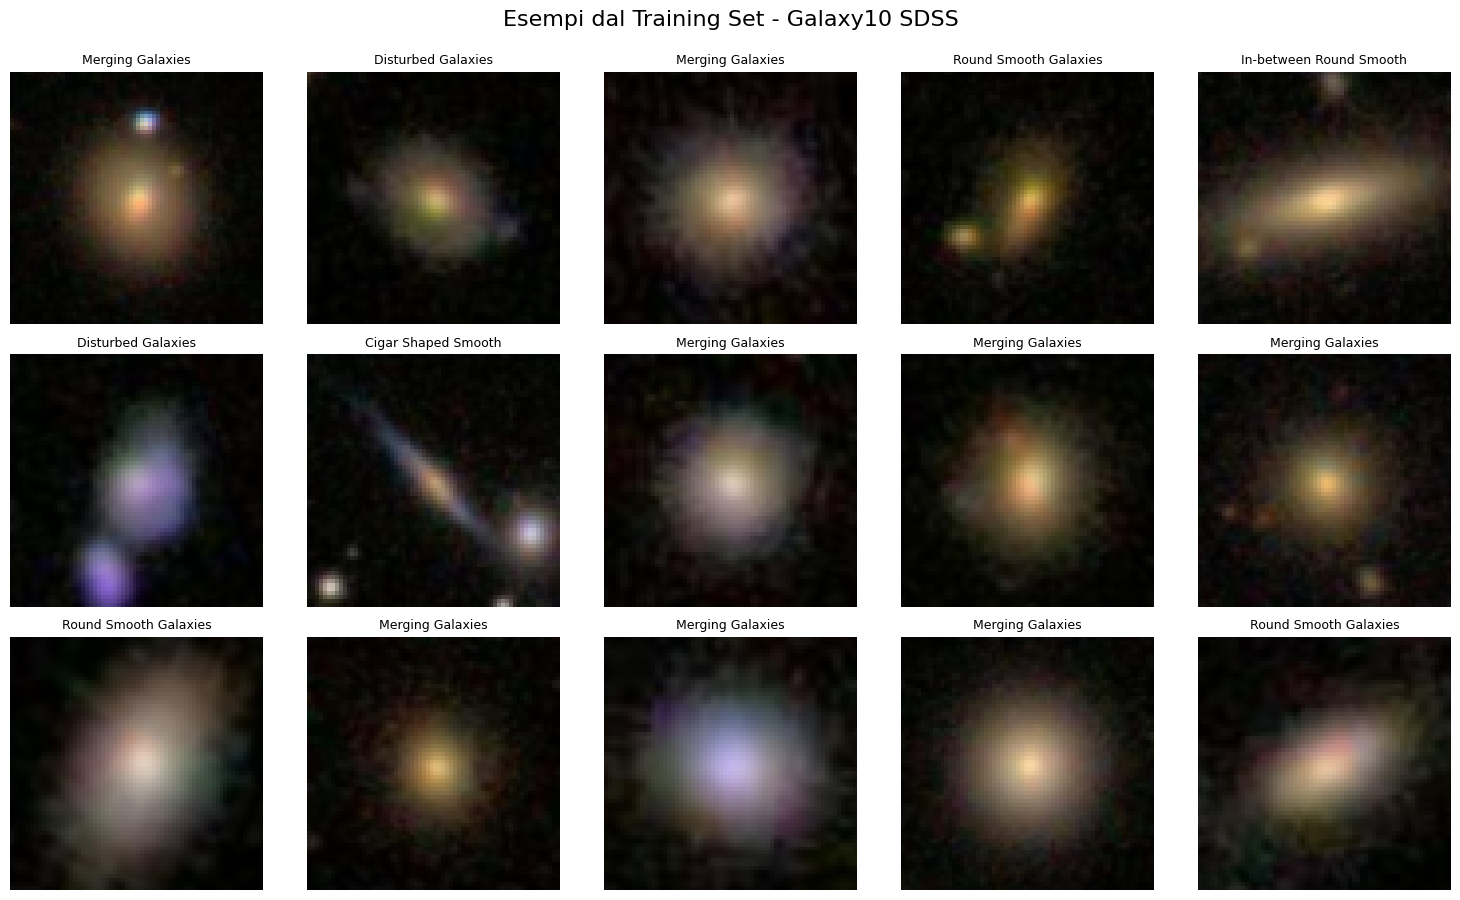


DATASET PRONTO PER IL TRAINING!
Variabili disponibili:
   - X_train, y_train: training set
   - X_val, y_val: validation set
   - X_test, y_test: test set
   - class_names: nomi delle 10 classi


In [ ]:
# Importa le librerie necessarie per il processing dei dati e la visualizzazione
import numpy as np  # Per operazioni matematiche e array multidimensionali
from sklearn.model_selection import train_test_split  # Per dividere il dataset in train/validation/test
import matplotlib.pyplot as plt  # Per visualizzare immagini e grafici

# Stampa un'intestazione per identificare la fase di caricamento del dataset
print("="*60)
print("CARICAMENTO DATASET GALAXY10 SDSS")
print("="*60)

# Tenta di importare il dataset Galaxy10, installandolo se non disponibile
try:
    from astroNN.datasets import galaxy10sdss  # Importa il dataset di galassie
except ImportError:
    # Se la libreria non è installata, la installa automaticamente
    print("Installazione astroNN...")
    !pip install astroNN  # Comando per installare la libreria (funziona in Jupyter/Colab)
    from astroNN.datasets import galaxy10sdss  # Reimporta dopo l'installazione

# Carica il dataset Galaxy10 SDSS dalla libreria astroNN
print("\nCaricamento dati da astroNN...")
images, labels = galaxy10sdss.load_data()  # Carica immagini e relative etichette

# Stampa le informazioni sul dataset caricato
print(f"Dataset caricato!")
print(f"Shape immagini originali: {images.shape}")  # Dimensioni del tensore delle immagini
print(f"Shape etichette: {labels.shape}")  # Dimensioni dell'array delle etichette
print(f"Numero di classi: {len(np.unique(labels))}")  # Conta le classi uniche nelle etichette
print(f"Dimensione immagini: {images.shape[1]}x{images.shape[2]}x{images.shape[3]}")  # HxWxC delle immagini

# Normalizza i valori dei pixel delle immagini dall'intervallo [0,255] a [0,1]
print("\nNormalizzazione immagini (0-1)...")
images = images.astype('float32') / 255.0  # Converti in float32 e dividi per 255

# Definisce la dimensione target per il ridimensionamento delle immagini
TARGET_SIZE = 64 # dimensione fissa in pixel delle immagini, 64x64
print(f"Ridimensionamento immagini a {TARGET_SIZE}x{TARGET_SIZE}...")
import tensorflow as tf  # Importa TensorFlow per le operazioni di ridimensionamento
# Ridimensiona tutte le immagini alla dimensione target usando TensorFlow
images_resized = tf.image.resize(images, [TARGET_SIZE, TARGET_SIZE]).numpy()

print(f"Immagini processate: {images_resized.shape}")  # Mostra le nuove dimensioni

# Divide il dataset in training, validation e test set
print("\nCreazione split Train/Validation/Test...")

# Prima divisione: separa l'80% per training+validation e il 20% per test
X_temp, X_test, y_temp, y_test = train_test_split(
    images_resized, labels,  # Dati da dividere
    test_size=0.2,  # 20% per il test set
    random_state=42,  # Seed per riproducibilità
    stratify=labels  # Mantiene la proporzione delle classi in tutti gli split
)

# Seconda divisione: separa il temporaneo in 75% training e 25% validation
# Risultato finale: 60% training, 20% validation, 20% test
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,  # Il subset temporaneo dalla prima divisione
    test_size=0.25,  # 25% del temporaneo va al validation (20% del totale)
    random_state=42,  # Stesso seed per consistenza
    stratify=y_temp  # Mantiene la distribuzione delle classi
)

# Calcola e mostra le statistiche degli split
total_samples = len(images_resized)  # Numero totale di campioni
print(f"\nRIEPILOGO SPLIT:")
print(f"   Training:   {len(X_train):5d} immagini ({len(X_train)/total_samples*100:.1f}%)")  # Set di training
print(f"   Validation: {len(X_val):5d} immagini ({len(X_val)/total_samples*100:.1f}%)")  # Set di validazione
print(f"   Test:       {len(X_test):5d} immagini ({len(X_test)/total_samples*100:.1f}%)")  # Set di test
print(f"   Totale:     {total_samples:5d} immagini (100.0%)")  # Totale complessivo

# Definisce i nomi descrittivi per le 10 classi di galassie nel dataset
class_names = [
    'Disturbed Galaxies',           # 0 - Galassie disturbate
    'Merging Galaxies',             # 1 - Galassie in fusione
    'Round Smooth Galaxies',        # 2 - Galassie rotonde e lisce
    'In-between Round Smooth',      # 3 - Galassie intermedie rotonde lisce
    'Cigar Shaped Smooth',          # 4 - Galassie lisce a forma di sigaro
    'Barred Spiral Galaxies',       # 5 - Galassie spirali barrate
    'Unbarred Tight Spiral',        # 6 - Galassie spirali strette non barrate
    'Unbarred Loose Spiral',        # 7 - Galassie spirali larghe non barrate
    'Edge-on without Bulge',        # 8 - Galassie di taglio senza rigonfiamento
    'Edge-on with Bulge'            # 9 - Galassie di taglio con rigonfiamento
]

# Analizza e mostra la distribuzione delle classi nel training set
print(f"\nDISTRIBUZIONE CLASSI NEL TRAINING SET:")
unique, counts = np.unique(y_train, return_counts=True)  # Trova classi uniche e le loro frequenze
for cls, count in zip(unique, counts):
    # Stampa per ogni classe: numero, nome (troncato a 25 caratteri) e conteggio
    print(f"   Classe {cls} ({class_names[cls][:25]:25s}): {count:4d} immagini")

# Crea una visualizzazione di esempio con 15 immagini casuali dal training set
print("\nVisualizzazione esempi dal training set...")
fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # Crea una griglia 3x5 di subplot
indices = np.random.choice(len(X_train), 15, replace=False)  # Seleziona 15 indici casuali unici

# Per ogni subplot, mostra un'immagine con la sua etichetta
for i, (ax, idx) in enumerate(zip(axes.flat, indices)):
    ax.imshow(X_train[idx])  # Mostra l'immagine nel subplot
    ax.set_title(f"{class_names[y_train[idx]]}", fontsize=9)  # Titolo con nome della classe
    ax.axis('off')  # Rimuove gli assi per una visualizzazione più pulita

# Aggiunge un titolo principale alla figura
plt.suptitle('Esempi dal Training Set - Galaxy10 SDSS', fontsize=16, y=0.995)
plt.tight_layout()  # Ottimizza lo spazio tra i subplot
plt.show()  # Mostra la figura

# Stampa un messaggio finale di conferma con le variabili disponibili
print("\n" + "="*60)
print("DATASET PRONTO PER IL TRAINING!")
print("="*60)
print("Variabili disponibili:")
print("   - X_train, y_train: training set")  # Dati per l'addestramento
print("   - X_val, y_val: validation set")  # Dati per la validazione durante l'addestramento
print("   - X_test, y_test: test set")  # Dati per il test finale del modello
print("   - class_names: nomi delle 10 classi")  # Nomi descrittivi delle categorie
print("="*60)

In [ ]:
# Importa tutte le librerie necessarie per il fine-tuning
import torch
from diffusers import StableDiffusionPipeline, DDPMScheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm.auto import tqdm
import os
from peft import LoraConfig, get_peft_model
import gc  # Garbage collector per gestione memoria

print("="*60)
print("FINE-TUNING DI DUE MODELLI CON LoRA SU GALAXY10")
print("="*60)

# CLASSE DI CONFIGURAZIONE per parametri centralizzati
class Config:
    # DIZIONARIO CON I DUE MODELLI DA FARE FINE-TUNING
    models = {
        "SD15": "runwayml/stable-diffusion-v1-5",  # Stable Diffusion v1.5
        "OpenJourney": "prompthero/openjourney"    # OpenJourney (variante di SD)
    }
    
    # Parametri di training condivisi tra i modelli
    learning_rate = 1e-4  # Tasso di apprendimento
    num_epochs = 3  # Numero di epoche di training
    batch_size = 1  # Dimensione batch (piccola per CPU)
    gradient_accumulation_steps = 8  # Accumula gradienti per simulare batch più grandi
    
    # Configurazione LoRA per efficientamento memoria
    lora_rank = 4  # Rango della decomposizione LoRA
    lora_alpha = 4  # Parametro alpha per LoRA
    lora_dropout = 0.1  # Dropout per prevenire overfitting
    
    # Dimensioni dataset ridotte per risparmiare memoria e tempo
    max_train_samples = 100  # Massimo campioni di training
    max_val_samples = 20  # Massimo campioni di validazione
    
    # Directory di output per salvare i modelli addestrati
    output_dirs = {
        "SD15": "galaxy10_sd15_lora",  # Directory per SD1.5
        "OpenJourney": "galaxy10_openjourney_lora"  # Directory per OpenJourney
    }
    
    # Configurazione hardware
    device = "cpu"  # Dispositivo di esecuzione (CPU)
    weight_dtype = torch.float32  # Tipo di dato per i pesi

# Crea istanza della configurazione
config = Config()

# Stampa informazioni di configurazione
print(f"Device: {config.device}")
print(f"Modelli da addestrare: {list(config.models.keys())}")
print(f"Train samples: {config.max_train_samples}")

# CLASSE DATASET per gestire i dati di training
class LightGalaxyDataset(Dataset):
    """Dataset leggero per immagini galassie con subset ridotto"""
    
    def __init__(self, images, labels, class_names, max_samples=None):
        # Seleziona solo un subset dei dati se specificato
        if max_samples and max_samples < len(images):
            # Campiona casualmente senza ripetizione
            indices = np.random.choice(len(images), max_samples, replace=False)
            self.images = images[indices]
            self.labels = labels[indices]
        else:
            # Usa tutti i dati disponibili
            self.images = images
            self.labels = labels
        
        self.class_names = class_names  # Nomi delle classi di galassie
        
        # Trasformazioni per pre-processing immagini
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),  # Ridimensiona a 256x256
            transforms.ToTensor(),  # Converte in tensore PyTorch
            transforms.Normalize([0.5], [0.5])  # Normalizza tra -1 e 1
        ])
    
    def __len__(self):
        """Restituisce il numero totale di campioni nel dataset"""
        return len(self.images)
    
    def __getitem__(self, idx):
        """Restituisce un singolo campione dal dataset"""
        image = self.images[idx]
        # Se l'immagine è normalizzata (0-1), riconverti a 0-255
        if image.max() <= 1.0:
            image = (image * 255).astype(np.uint8)
        
        # Converti array numpy in immagine PIL
        pil_image = Image.fromarray(image)
        # Applica le trasformazioni definite
        image_tensor = self.transform(pil_image)
        
        # Ottieni l'indice della classe e crea il prompt descrittivo
        class_idx = self.labels[idx]
        prompt = f"a telescope image of {self.class_names[class_idx].lower()}"
        
        return {
            "pixel_values": image_tensor,  # Tensore dell'immagine
            "prompt": prompt  # Prompt testuale associato
        }

# Prepara il dataset e dataloader per il training
print("\nPreparazione dataset...")
train_dataset = LightGalaxyDataset(
    X_train, y_train, class_names,
    max_samples=config.max_train_samples
)

# Crea DataLoader per il training
train_dataloader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,  # Batch size piccolo
    shuffle=True,  # Mescola i dati ad ogni epoca
    num_workers=0  # 0 worker per CPU, sono processi o thread secondari che lavorano in parallelo per svolgere compiti specifici, il loro scopo principale è accelerare il caricamento e la preparazione dei dati
)

print(f"Training samples: {len(train_dataset)}")

# Funzione di training per un singolo modello
def train_model(model_name, model_id, output_dir):
    """Addestra un singolo modello con LoRA sul dataset Galaxy10"""
    
    print("\n" + "="*60)
    print(f"TRAINING: {model_name}")
    print("="*60)
    
    # Carica il modello pre-addestrato da Hugging Face
    print(f"\nCaricamento {model_name}...")
    pipe = StableDiffusionPipeline.from_pretrained(
        model_id,  # ID del modello su Hugging Face
        torch_dtype=config.weight_dtype,  # Tipo di dato
        safety_checker=None,  # Disabilita safety checker
        requires_safety_checker=False,  # Disabilita requirement safety checker
        low_cpu_mem_usage=True  # Ottimizza uso memoria CPU
    )
    
    # Estrai i componenti individuali della pipeline
    unet = pipe.unet.to(config.device)  # Modello di diffusione
    vae = pipe.vae.to(config.device)  # Autoencoder variazionale
    text_encoder = pipe.text_encoder.to(config.device)  # Encoder del testo
    tokenizer = pipe.tokenizer  # Tokenizer per il testo
    # Carica il scheduler di noise specifico per il modello
    noise_scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")
    
    # Congela i parametri di VAE e text_encoder - non verranno addestrati
    vae.requires_grad_(False)
    text_encoder.requires_grad_(False)
    # Imposta in modalità evaluation per efficienza
    vae.eval()
    text_encoder.eval()
    
    # Applicazione di LoRA al modello UNet per efficientamento
    print("Applicazione LoRA...")
    lora_config = LoraConfig(
        r=config.lora_rank,  # Rango della decomposizione
        lora_alpha=config.lora_alpha,  # Parametro alpha
        init_lora_weights="gaussian",  # Inizializzazione pesi
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],  # Layer attention target
        lora_dropout=config.lora_dropout,  # Tasso dropout
    )
    
    # Applica la configurazione LoRA al modello UNet
    unet = get_peft_model(unet, lora_config)
    # Stampa informazioni sui parametri trainabili
    unet.print_trainable_parameters()
    
    # Configura l'optimizer per i parametri trainabili
    optimizer = torch.optim.AdamW(
        unet.parameters(),  # Solo parametri di UNet (con LoRA)
        lr=config.learning_rate,  # Tasso di apprendimento
        weight_decay=0.01  # Decay pesi per regolarizzazione
    )
    
    # LOOP PRINCIPALE DI TRAINING
    print(f"\nInizio training {model_name}...")
    global_step = 0  # Contatore step globali
    unet.train()  # Imposta il modello in modalità training
    
    # Loop sulle epoche
    for epoch in range(config.num_epochs):
        print(f"\nEPOCH {epoch+1}/{config.num_epochs}")
        epoch_loss = 0  # Accumulatore loss per l'epoca
        # Barra di progresso per monitorare il training
        progress_bar = tqdm(train_dataloader, desc=f"{model_name} Epoch {epoch+1}")
        
        # Loop sui batch del dataloader
        for step, batch in enumerate(progress_bar):
            pixel_values = batch["pixel_values"].to(config.device)  # Immagini
            prompts = batch["prompt"]  # Prompt testuali
            
            # Codifica i prompt testuali con il tokenizer
            text_inputs = tokenizer(
                prompts,
                padding="max_length",  # Padding alla lunghezza massima
                max_length=tokenizer.model_max_length,  # Lunghezza massima tokenizer
                truncation=True,  # Tronca se troppo lungo
                return_tensors="pt"  # Restituisci tensori PyTorch
            )
            
            # Calcola embeddings senza calcolare gradienti (modelli congelati)
            with torch.no_grad():
                text_embeddings = text_encoder(text_inputs.input_ids.to(config.device))[0]
                # Codifica immagini in spazio latente con VAE
                latents = vae.encode(pixel_values).latent_dist.sample()
                latents = latents * vae.config.scaling_factor  # Applica scaling factor
            
            # Aggiungi rumore gaussiano ai latenti
            noise = torch.randn_like(latents)
            # Genera timestep casuali per il processo di diffusione
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps,
                (latents.shape[0],),
                device=config.device
            ).long()
            
            # Aggiungi rumore ai latenti secondo i timestep
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
            
            # Predizione del rumore con il modello UNet
            noise_pred = unet(noisy_latents, timesteps, text_embeddings).sample
            
            # Calcola la loss come errore quadratico medio tra rumore predetto e reale
            loss = torch.nn.functional.mse_loss(noise_pred, noise)
            # Scala la loss per accumulation steps
            loss = loss / config.gradient_accumulation_steps
            
            # Backpropagation
            loss.backward()
            
            # Aggiorna i pesi solo dopo accumulation steps
            if (step + 1) % config.gradient_accumulation_steps == 0:
                optimizer.step()  # Aggiorna pesi
                optimizer.zero_grad()  # Azzera gradienti
                global_step += 1  # Incrementa contatore globale
            
            # Aggiorna statistiche epoca
            epoch_loss += loss.item() * config.gradient_accumulation_steps
            progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
            
            # Pulizia memoria per prevenire memory leak
            del noise_pred, noisy_latents, latents, text_embeddings
            gc.collect()  # Forza garbage collection
        
        # Calcola e stampa la loss media dell'epoca
        avg_loss = epoch_loss / len(train_dataloader)
        print(f"Epoch {epoch+1} - Loss media: {avg_loss:.4f}")
    
    # Salvataggio del modello addestrato
    print(f"\nSalvataggio {model_name} LoRA...")
    os.makedirs(output_dir, exist_ok=True)  # Crea directory se non esiste
    unet.save_pretrained(output_dir)  # Salva solo i pesi LoRA
    print(f"Salvato in: {output_dir}/")
    
    # Pulizia memoria finale per liberare risorse
    del unet, vae, text_encoder, pipe
    gc.collect()

# training dei due modelli
print("\n" + "="*60)
print("INIZIO TRAINING DI ENTRAMBI I MODELLI")
print("="*60)

# Training del primo modello: Stable Diffusion 1.5
train_model(
    model_name="Stable Diffusion 1.5",
    model_id=config.models["SD15"],
    output_dir=config.output_dirs["SD15"]
)

# Training del secondo modello: OpenJourney
train_model(
    model_name="OpenJourney",
    model_id=config.models["OpenJourney"],
    output_dir=config.output_dirs["OpenJourney"]
)

# Messaggio finale di conferma
print("\n" + "="*60)
print("TRAINING COMPLETATO PER ENTRAMBI I MODELLI")
print("="*60)
print(f"\nModelli salvati:")
print(f"  - SD 1.5: {config.output_dirs['SD15']}/")
print(f"  - OpenJourney: {config.output_dirs['OpenJourney']}/")

FINE-TUNING DI DUE MODELLI CON LoRA SU GALAXY10
Device: cpu
Modelli da addestrare: ['SD15', 'OpenJourney']
Train samples: 100

Preparazione dataset...
Training samples: 100

INIZIO TRAINING DI ENTRAMBI I MODELLI

TRAINING: Stable Diffusion 1.5

Caricamento Stable Diffusion 1.5...


Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  5.70it/s]


Applicazione LoRA...
trainable params: 797,184 || all params: 860,318,148 || trainable%: 0.0927

Inizio training Stable Diffusion 1.5...

EPOCH 1/3


Stable Diffusion 1.5 Epoch 1: 100%|██████████| 100/100 [14:28<00:00,  8.69s/it, loss=0.0010]


Epoch 1 - Loss media: 0.1592

EPOCH 2/3


Stable Diffusion 1.5 Epoch 2: 100%|██████████| 100/100 [15:58<00:00,  9.58s/it, loss=0.0225]


Epoch 2 - Loss media: 0.1359

EPOCH 3/3


Stable Diffusion 1.5 Epoch 3: 100%|██████████| 100/100 [15:23<00:00,  9.23s/it, loss=0.0010]


Epoch 3 - Loss media: 0.1660

Salvataggio Stable Diffusion 1.5 LoRA...
Salvato in: galaxy10_sd15_lora/

TRAINING: OpenJourney

Caricamento OpenJourney...


Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.88it/s]


Applicazione LoRA...
trainable params: 797,184 || all params: 860,318,148 || trainable%: 0.0927

Inizio training OpenJourney...

EPOCH 1/3


OpenJourney Epoch 1: 100%|██████████| 100/100 [17:43<00:00, 10.63s/it, loss=0.0238]


Epoch 1 - Loss media: 0.1497

EPOCH 2/3


OpenJourney Epoch 2: 100%|██████████| 100/100 [16:51<00:00, 10.12s/it, loss=0.0063]


Epoch 2 - Loss media: 0.1407

EPOCH 3/3


OpenJourney Epoch 3: 100%|██████████| 100/100 [17:58<00:00, 10.79s/it, loss=0.0310]


Epoch 3 - Loss media: 0.1515

Salvataggio OpenJourney LoRA...
Salvato in: galaxy10_openjourney_lora/

TRAINING COMPLETATO PER ENTRAMBI I MODELLI

Modelli salvati:
  - SD 1.5: galaxy10_sd15_lora/
  - OpenJourney: galaxy10_openjourney_lora/


TEST COMPARATIVO MODELLI FINE-TUNED SU GALAXY10

INIZIALIZZAZIONE MODELLI...

Caricamento Stable Diffusion 1.5...


Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  7.66it/s]


Applicazione adapter LoRA per Stable Diffusion 1.5...
Stable Diffusion 1.5 caricato con successo

Caricamento OpenJourney...


Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  5.66it/s]


Applicazione adapter LoRA per OpenJourney...
OpenJourney caricato con successo

GENERAZIONE IMMAGINI DI TEST
Numero di prompt: 7
Parametri: 25 steps, 256x256px
NOTA: Su CPU ogni immagine richiede circa 1-2 minuti
Tempo totale stimato: 21 minuti


Generazione 7 immagini con Stable Diffusion 1.5...
  [1/7] A telescope image of merging galaxies


100%|██████████| 25/25 [02:26<00:00,  5.88s/it]


  [2/7] An indigo spiral galaxy with 6 arms


100%|██████████| 25/25 [02:10<00:00,  5.23s/it]


  [3/7] Pink and purple nebula


100%|██████████| 25/25 [02:10<00:00,  5.21s/it]


  [4/7] An astronaut outside of the ISS


100%|██████████| 25/25 [02:12<00:00,  5.31s/it]


  [5/7] Pink moon phenomenon


100%|██████████| 25/25 [02:14<00:00,  5.36s/it]


  [6/7] A detailed picture of Uranus


100%|██████████| 25/25 [02:12<00:00,  5.31s/it]


  [7/7] Green star forming region


100%|██████████| 25/25 [02:15<00:00,  5.43s/it]



Generazione 7 immagini con OpenJourney...
  [1/7] A telescope image of merging galaxies


100%|██████████| 25/25 [02:11<00:00,  5.27s/it]


  [2/7] An indigo spiral galaxy with 6 arms


100%|██████████| 25/25 [02:05<00:00,  5.02s/it]


  [3/7] Pink and purple nebula


100%|██████████| 25/25 [02:40<00:00,  6.44s/it]


  [4/7] An astronaut outside of the ISS


100%|██████████| 25/25 [02:13<00:00,  5.34s/it]


  [5/7] Pink moon phenomenon


100%|██████████| 25/25 [02:16<00:00,  5.45s/it]


  [6/7] A detailed picture of Uranus


100%|██████████| 25/25 [02:11<00:00,  5.25s/it]


  [7/7] Green star forming region


100%|██████████| 25/25 [02:06<00:00,  5.07s/it]



VISUALIZZAZIONE RISULTATI COMPARATIVI


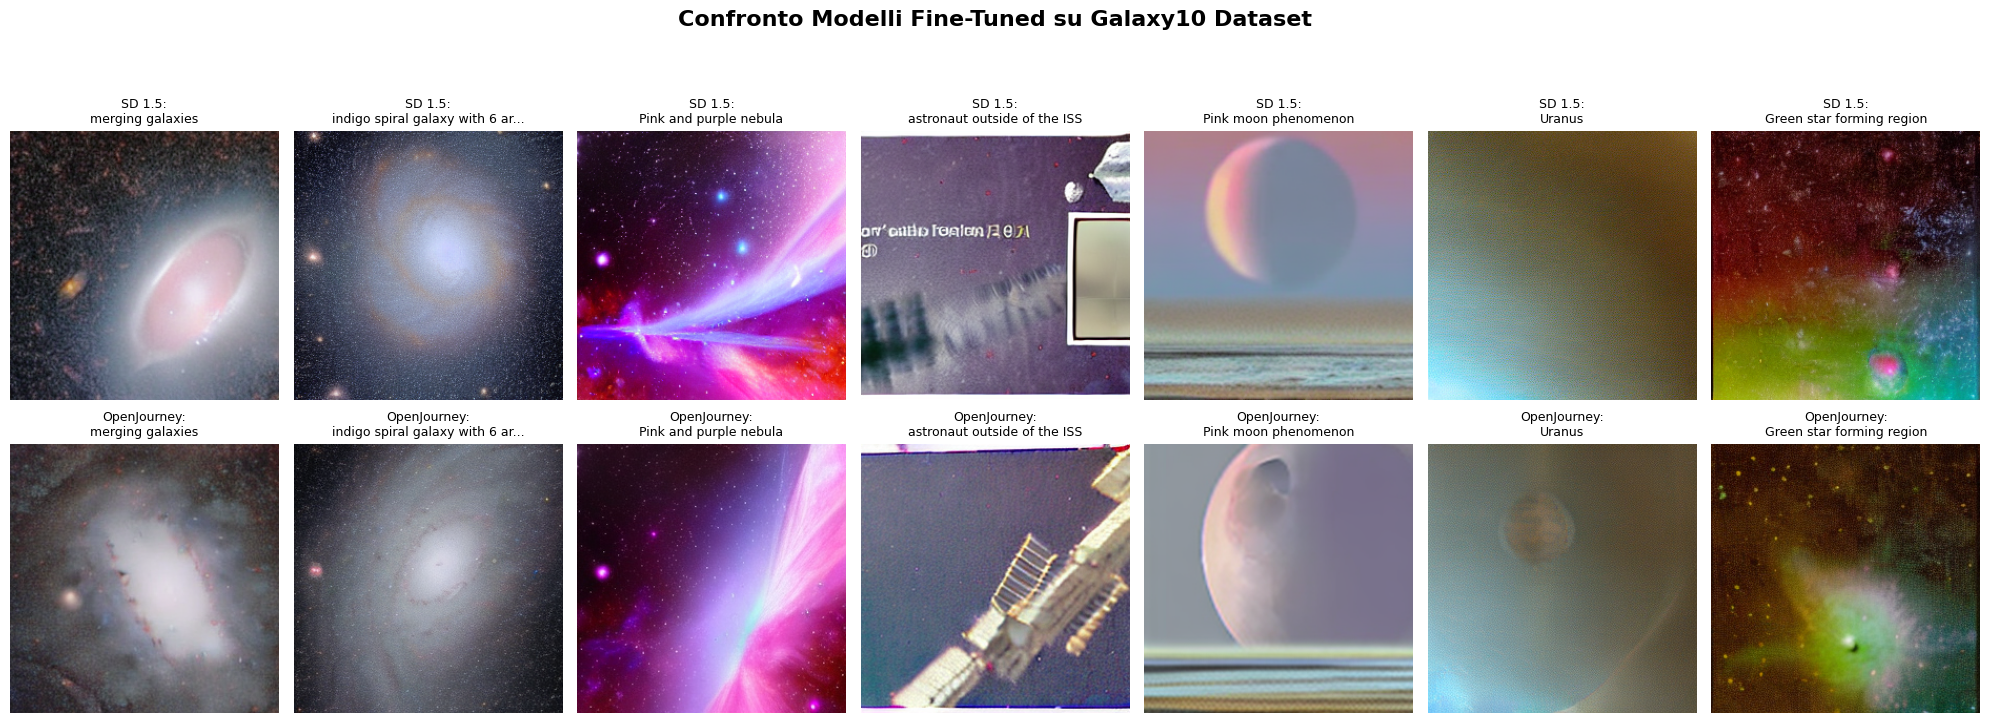


RIEPILOGO COMPARATIVO

Modelli testati:
  - Stable Diffusion 1.5: galaxy10_sd15_lora/
  - OpenJourney: galaxy10_openjourney_lora/

Parametri di generazione:
  - Inference steps: 25
  - Dimensione immagini: 256x256px
  - Guidance scale: 7.5
  - Dispositivo: cpu

Prompt testati: 7
  1. A telescope image of merging galaxies
  2. An indigo spiral galaxy with 6 arms
  3. Pink and purple nebula
  4. An astronaut outside of the ISS
  5. Pink moon phenomenon
  6. A detailed picture of Uranus
  7. Green star forming region

Test completato! Confronto visivo disponibile sopra.
Osserva le differenze stilistiche tra i due modelli fine-tuned.


In [13]:
# Importa le librerie necessarie per il testing dei modelli fine-tuned
from peft import PeftModel  # Per caricare i modelli con adapter LoRA
import torch  # PyTorch per il calcolo tensoriale
from diffusers import StableDiffusionPipeline  # Pipeline per la generazione di immagini
import matplotlib.pyplot as plt  # Per la visualizzazione delle immagini
import gc  # Garbage collector per la gestione della memoria

print("="*60)
print("TEST COMPARATIVO MODELLI FINE-TUNED SU GALAXY10")
print("="*60)

# Configurazione per l'esecuzione su CPU
device = "cpu"  # Dispositivo di esecuzione
dtype = torch.float32  # Tipo di dato per i tensori (float32 su CPU)

# Definisce i prompt di test basati sulle classi Galaxy10 e temi astronomici
test_prompts = [
    "A telescope image of merging galaxies",  # Galassie in fusione
    "An indigo spiral galaxy with 6 arms",    # Galassia spirale con 6 bracci
    "Pink and purple nebula",                 # Nebulosa rosa e viola
    "An astronaut outside of the ISS",        # Astronauta fuori dalla ISS
    "Pink moon phenomenon",                   # Fenomeno della luna rosa
    "A detailed picture of Uranus",           # Immagine dettagliata di Urano
    "Green star forming region"               # Regione di formazione stellare verde
]

# Parametri ottimizzati per l'esecuzione su CPU
num_inference_steps = 25  # Ridotto da 50 a 25 per velocizzare la generazione
height = 256  # Altezza ridotta da 512 a 256 pixel per risparmiare memoria
width = 256   # Larghezza ridotta da 512 a 256 pixel
guidance_scale = 7.5  # Scala di guida per il prompt (classifier-free guidance)

# FUNZIONE PER CARICARE UN MODELLO CON LoRA
def load_model_with_lora(model_name, base_model_id, lora_path):
    """
    Carica un modello base e applica i pesi LoRA addestrati
    
    Args:
        model_name: Nome descrittivo del modello
        base_model_id: ID del modello base su Hugging Face
        lora_path: Percorso alla directory dei pesi LoRA
    
    Returns:
        Pipeline del modello configurato
    """
    print(f"\nCaricamento {model_name}...")
    
    # Carica il modello base
    pipe = StableDiffusionPipeline.from_pretrained(
        base_model_id,
        torch_dtype=dtype,
        safety_checker=None,
        requires_safety_checker=False,
        low_cpu_mem_usage=True
    )
    
    # Applica gli adapter LoRA addestrati al modello UNet
    print(f"Applicazione adapter LoRA per {model_name}...")
    pipe.unet = PeftModel.from_pretrained(pipe.unet, lora_path)
    
    # Configura ottimizzazioni per CPU
    pipe = pipe.to(device)
    pipe.enable_attention_slicing()  # Divide l'attention per ridurre memoria
    pipe.enable_vae_slicing()  # Divide il VAE per ridurre memoria
    
    print(f"{model_name} caricato con successo")
    return pipe

# CARICA ENTRAMBI I MODELLI FINE-TUNED
print("\nINIZIALIZZAZIONE MODELLI...")

# Carica Stable Diffusion 1.5 con LoRA
sd_pipe = load_model_with_lora(
    model_name="Stable Diffusion 1.5",
    base_model_id="runwayml/stable-diffusion-v1-5",
    lora_path="galaxy10_sd15_lora"
)

# Carica OpenJourney con LoRA
oj_pipe = load_model_with_lora(
    model_name="OpenJourney",
    base_model_id="prompthero/openjourney", 
    lora_path="galaxy10_openjourney_lora"
)

# FUNZIONE PER GENERARE IMMAGINI CON UN MODELLO
def generate_images(pipe, model_name, prompts, num_inference_steps, guidance_scale, height, width):
    """
    Genera immagini per una lista di prompt usando un modello specifico
    
    Args:
        pipe: Pipeline del modello
        model_name: Nome del modello per logging
        prompts: Lista di prompt testuali
        num_inference_steps: Numero di passi di inferenza
        guidance_scale: Scala di guida per il prompt
        height: Altezza immagine
        width: Larghezza immagine
    
    Returns:
        Lista di immagini generate
    """
    print(f"\nGenerazione {len(prompts)} immagini con {model_name}...")
    images = []
    
    for i, prompt in enumerate(prompts):
        print(f"  [{i+1}/{len(prompts)}] {prompt}")
        
        # Crea generatore con seed per riproducibilità
        generator = torch.Generator(device=device).manual_seed(42 + i)
        
        # Genera l'immagine
        image = pipe(
            prompt=prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            height=height,
            width=width,
            generator=generator
        ).images[0]  # Prende la prima immagine generata
        
        images.append(image)
        
        # Pulizia memoria dopo ogni generazione
        gc.collect()
    
    return images

# GENERAZIONE IMMAGINI CON ENTRAMBI I MODELLI
print("\n" + "="*60)
print("GENERAZIONE IMMAGINI DI TEST")
print("="*60)

print(f"Numero di prompt: {len(test_prompts)}")
print(f"Parametri: {num_inference_steps} steps, {height}x{width}px")
print("NOTA: Su CPU ogni immagine richiede circa 1-2 minuti")
print(f"Tempo totale stimato: {len(test_prompts) * 2 * 1.5:.0f} minuti\n")

# Genera immagini con Stable Diffusion 1.5
sd_images = generate_images(
    pipe=sd_pipe,
    model_name="Stable Diffusion 1.5",
    prompts=test_prompts,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    height=height,
    width=width
)

# Genera immagini con OpenJourney
oj_images = generate_images(
    pipe=oj_pipe, 
    model_name="OpenJourney",
    prompts=test_prompts,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    height=height,
    width=width
)

# VISUALIZZAZIONE COMPARATIVA
print("\n" + "="*60)
print("VISUALIZZAZIONE RISULTATI COMPARATIVI")
print("="*60)

# Crea una figura per visualizzare il confronto affiancato
# Layout: 2 righe (modelli) x N colonne (prompts)
fig, axes = plt.subplots(2, len(test_prompts), figsize=(20, 8))

# Funzione per creare titoli più leggibili
def create_clean_title(prompt):
    """Pulisce il prompt per creare un titolo più compatto"""
    clean_prompt = prompt.replace("A telescope image of ", "")\
                        .replace("An ", "")\
                        .replace("A detailed picture of ", "")
    return clean_prompt[:30] + "..." if len(clean_prompt) > 30 else clean_prompt

# Visualizza immagini Stable Diffusion (prima riga)
for i, (image, prompt) in enumerate(zip(sd_images, test_prompts)):
    axes[0, i].imshow(image)
    axes[0, i].set_title(f"SD 1.5:\n{create_clean_title(prompt)}", fontsize=9)
    axes[0, i].axis('off')

# Visualizza immagini OpenJourney (seconda riga)
for i, (image, prompt) in enumerate(zip(oj_images, test_prompts)):
    axes[1, i].imshow(image)
    axes[1, i].set_title(f"OpenJourney:\n{create_clean_title(prompt)}", fontsize=9)
    axes[1, i].axis('off')

# Aggiunge titoli alle righe per chiarezza
axes[0, 0].set_ylabel('Stable Diffusion 1.5', rotation=90, size='large', fontweight='bold')
axes[1, 0].set_ylabel('OpenJourney', rotation=90, size='large', fontweight='bold')

# Titolo principale della figura
plt.suptitle('Confronto Modelli Fine-Tuned su Galaxy10 Dataset', fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Spazio per il titolo principale
plt.show()

# ANALISI COMPARATIVA FINALE
print("\n" + "="*60)
print("RIEPILOGO COMPARATIVO")
print("="*60)

print(f"\nModelli testati:")
print(f"  - Stable Diffusion 1.5: galaxy10_sd15_lora/")
print(f"  - OpenJourney: galaxy10_openjourney_lora/")

print(f"\nParametri di generazione:")
print(f"  - Inference steps: {num_inference_steps}")
print(f"  - Dimensione immagini: {height}x{width}px")
print(f"  - Guidance scale: {guidance_scale}")
print(f"  - Dispositivo: {device}")

print(f"\nPrompt testati: {len(test_prompts)}")
for i, prompt in enumerate(test_prompts, 1):
    print(f"  {i}. {prompt}")

print(f"\nTest completato! Confronto visivo disponibile sopra.")
print("Osserva le differenze stilistiche tra i due modelli fine-tuned.")